ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **29Sep21**

# 05. Rayleigh-Ritz Method
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Problem Statement](#problem)
 + [Poisson Problem](#poisson)
---

## [Objectives](#toc)<a id="obj"></a>

 + Rayleigh-Ritz method for solving linear differential equations with symmetric positive definite operators ([OneNote notes](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eg7XSdAYHC9Fpzxuz2aMXMwBMl0tRiBq1Z5eLvvUq5auew?e=yueO0O)).

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the one-dimensional Poisson problem with homogeneous Dirichlet boundary conditions.

### [Poisson Problem Statement](#toc)<a id="poisson"></a>

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 -\bigl(-D(x)\, u'\bigr)'(x) + S(x)\,u(x) + f(x) &= 0 \quad\quad \forall \quad\quad x\in [a,b], \\
 u(a) &= 0, \\
 u(b) &= 0.
\end{align*}
   
This problem is linear and has an analytical solution for given data: diffusion coefficient, $D(x)$, source, $S(x)$ slope, source bias, $f(x)$. The *diffusion flux* associated to the quantity $u$, is denoted $q := -D(x)\,u'$, and it is often of interest as a derived quantity.

The values of the dependent variable are given on the two end points of the domain. This is called *essential* boundary conditions or  *Dirichlet boundary conditions*. Since the values are equal to zero, the boundary condition is referred to as homogeneous.

## [Data](#toc)<a id="data"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 0 $s^{-1}$
> + f = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 3

In [183]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [184]:
'''Parameters and data'''

diff_coeff = 0.1
source_bias_value = 1e-2

u_a = 1
u_b = 1

# shape pts =  2


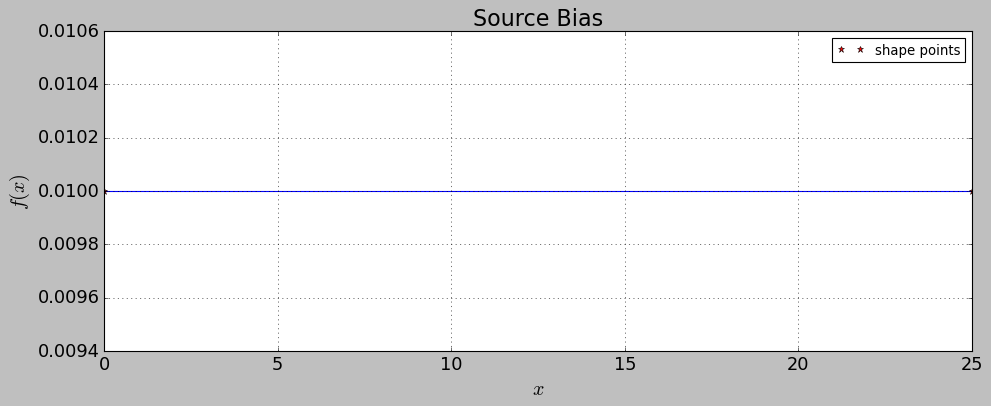

In [185]:
'''Generate the source bias'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(x_a,source_bias_value), (x_b,source_bias_value)]
print('# shape pts = ', len(shape_pts))

source_bias = TargetFunction(shape_pts, type='linear')
  
source_bias.plot(n_plot_pts=200, show_shape_pts=True, title='Source Bias')

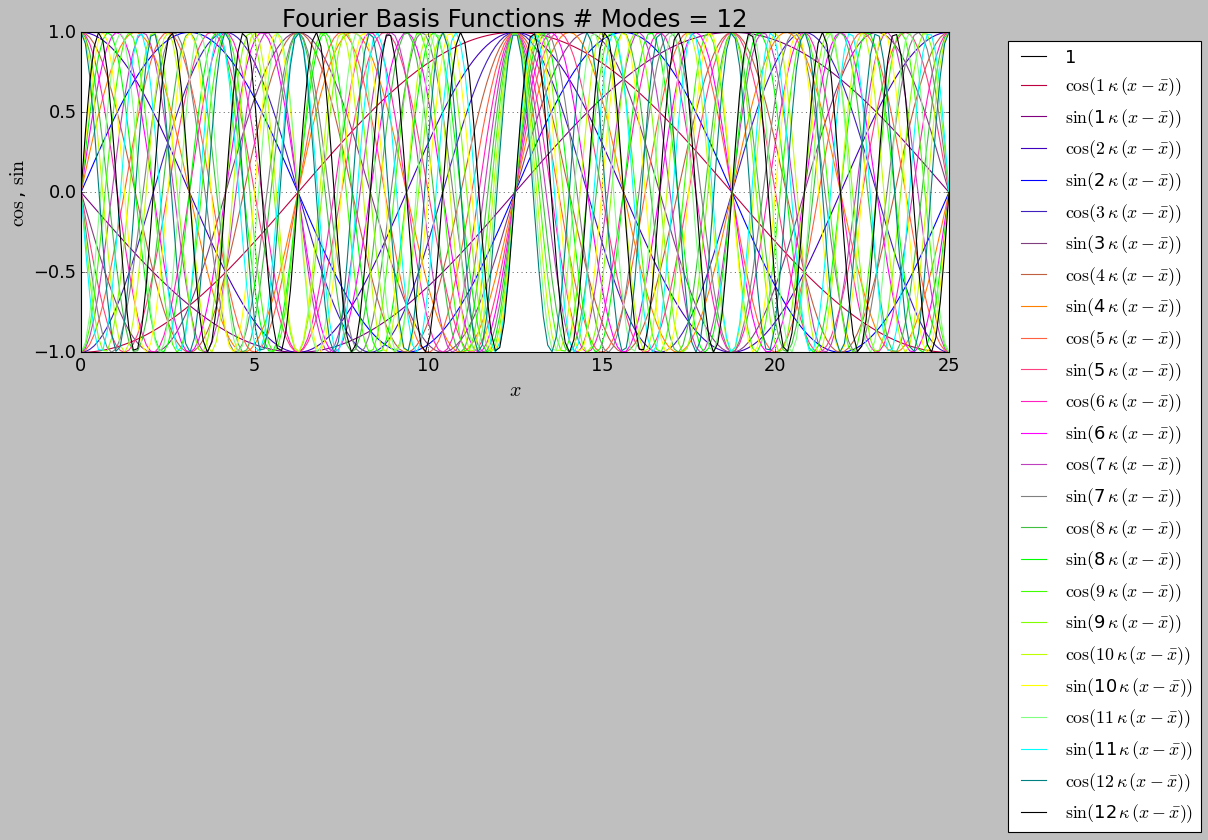

In [186]:
'''Build the basis functions list'''

import math

wavelength = x_b - x_a
kappa = 2*math.pi/wavelength

N = 12 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_a, x_b)
fb.plot()

In [187]:
import numpy as np
n = len(fb.basis_func_list)
a_mtrx = np.zeros((n, n), dtype=np.float64)
  
for i,phi_prime_i in enumerate(fb.basis_func_prime_list):
    for j,phi_prime_j in enumerate(fb.basis_func_prime_list):
        (a_ij, _) = fb.inner_product(phi_prime_j, phi_prime_i)
        a_mtrx[i,j] = a_ij * diff_coeff
        
for i,phi_prime_i in enumerate(fb.basis_func_prime_list):
    for j,phi_j in enumerate(fb.basis_func_list):
        a_mtrx[i,j] -= diff_coeff * (phi_j(x_b) * phi_prime_i(x_b) - phi_j(x_a) * phi_prime_i(x_a))

for i,phi_i in enumerate(fb.basis_func_list):
    for j,phi_j in enumerate(fb.basis_func_list):
        a_mtrx[i,j] += phi_i(x_a) * phi_j(x_a) + phi_i(x_b) * phi_j(x_b)

In [188]:
'''Build load vector'''

b_vec = np.zeros(n, dtype=np.float64)

for i, phi_i in enumerate(fb.basis_func_list):
    (b_vec[i], _) = fb.inner_product(source_bias, phi_i) 
    b_vec[i] += u_a*phi_i(x_a) + u_b*phi_i(x_b)               

In [189]:
'''Compute optimal coefficient vector'''

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

In [190]:
'''Build the best approximant function'''

def u_star(x_pts):
    a_mtrx = fb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

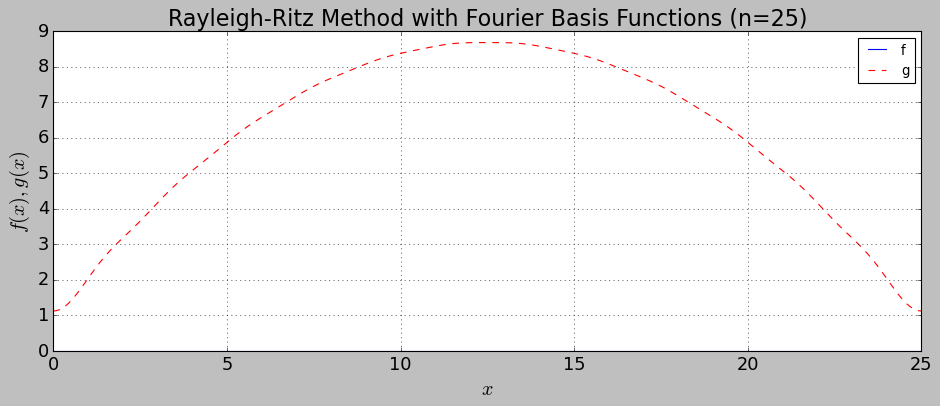

In [191]:
'''Rayleigh Ritz Method with Fourier Basis Functions'''

n_pts = 300
x = np.linspace(x_a, x_b, n_pts)

u_values = u_star(x)

source_bias.plot(g=(x, u_values), n_plot_pts=n_pts, title=r'Rayleigh-Ritz Method with Fourier Basis Functions (n='+str(len(fb.basis_func_list))+')')

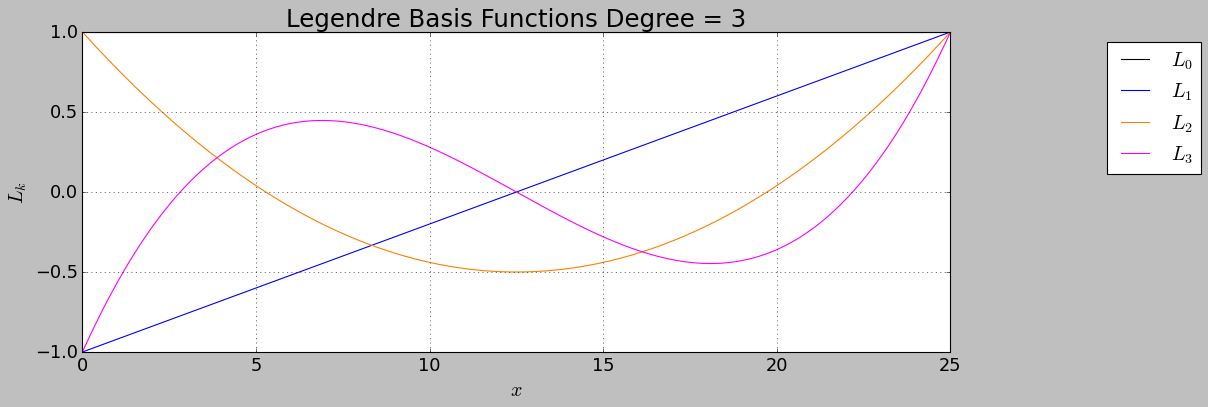

In [176]:
'''Build the basis functions'''

degree = 3

try:    
    from engy_5310.toolkit import LegendreBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
lb = LegendreBasis(degree, x_a, x_b)
lb.plot()

In [177]:
import numpy as np
n = len(lb.basis_func_list)
a_mtrx = np.zeros((n, n), dtype=np.float64)
  
for i,phi_prime_i in enumerate(lb.basis_func_prime_list):
    for j,phi_prime_j in enumerate(lb.basis_func_prime_list):
        (a_ij, _) = lb.inner_product(phi_prime_j, phi_prime_i)
        a_mtrx[i,j] = a_ij * 2/x_length * diff_coeff
        
for i,phi_prime_i in enumerate(lb.basis_func_prime_list):
    for j,phi_j in enumerate(lb.basis_func_list):
        a_mtrx[i,j] -= source_bias.values(x_b) * phi_j(x_b) * phi_prime_i(x_b) - source_bias.values(x_a) * phi_j(x_a) * phi_prime_i(x_a)

for i,phi_i in enumerate(lb.basis_func_list):
    for j,phi_j in enumerate(lb.basis_func_list):
        a_mtrx[i,j] += phi_i(x_a) * phi_j(x_a) + phi_i(x_b) * phi_j(x_b)

In [178]:
'''Build load vector'''

b_vec = np.zeros(n, dtype=np.float64)

for i, phi_i in enumerate(lb.basis_func_list):
    (b_vec[i], _) = lb.inner_product(source_bias, phi_i) 
    b_vec[i] += u_a*phi_i(x_a) + u_b*phi_i(x_b)               

In [179]:
'''Compute optimal coefficient vector'''

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

In [180]:
'''Build the best approximant function'''

def u_star(x_pts):
    a_mtrx = lb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

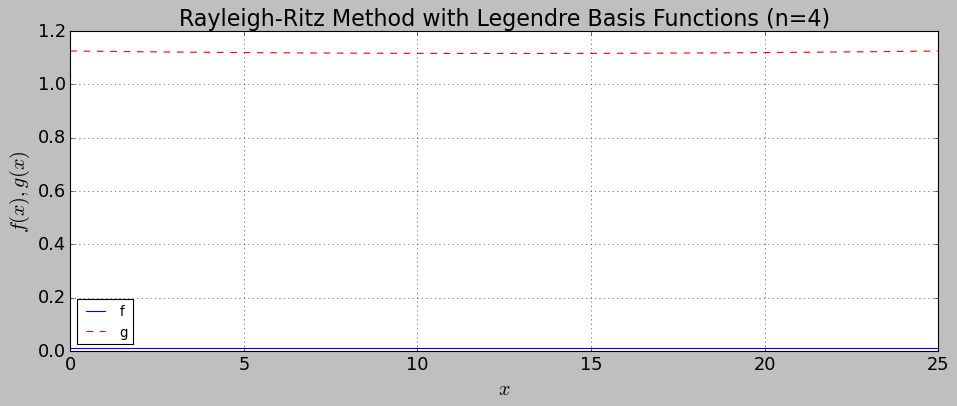

In [181]:
'''Rayleigh Ritz Method with Fourier Basis Functions'''

n_pts = 300
x = np.linspace(x_a, x_b, n_pts)

u_values = u_star(x)

source_bias.plot(g=(x, u_values), n_plot_pts=n_pts, title=r'Rayleigh-Ritz Method with Legendre Basis Functions (n='+str(len(lb.basis_func_list))+')')

In [182]:
c_star_vec

array([ 1.11881164e+00, -1.27528752e-18,  6.18836292e-03,  2.12829012e-20])